In [1]:
!git clone https://github.com/franksacco/where-is-wally.git
%cd where-is-wally

Cloning into 'where-is-wally'...
remote: Enumerating objects: 1150, done.
remote: Counting objects: 100% (1150/1150), done.
remote: Compressing objects: 100% (668/668), done.
remote: Total 2607 (delta 484), reused 1146 (delta 482), pack-reused 1457
Receiving objects: 100% (2607/2607), 916.15 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (641/641), done.
Checking out files: 100% (1417/1417), done.
/content/where-is-wally


# UNet

 - UNet — Line by Line Explanation: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
 - Learn How to Train U-Net On Your Dataset: https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623
 - Implementation of deep learning framework -- Unet, using Keras: https://github.com/zhixuhao/unet
 - Semantic segmentation with U-Net- train, and test on your custom data in Keras: https://medium.com/@pallawi.ds/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from keras import backend as K
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dropout, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf

Using TensorFlow backend.


In [0]:
IMG_WIDTH    = 256
IMG_HEIGHT   = 256
IMG_CHANNELS = 3

SEED             = 7       #@param{type: "slider", min: 0, max: 999}
BATCH_SIZE       = 14      #@param{type: "slider", min: 1, max: 16}
EPOCHS           = 100     #@param{type: "slider", min: 5, max: 150}
LOSS_FUNCTION    = 'f1lo'  #@param['bifo', 'wbce', 'dice', 'jacc', 'f1lo']

NAME = '%s-b%d-e%d' % (LOSS_FUNCTION, BATCH_SIZE, EPOCHS)

## Load dataset

In [0]:
NUM_SAMPLES = len(glob.glob('data/aug/train/*_image.jpg'))
NUM_SAMPLES_VAL = len(glob.glob('data/aug/val/*_image.jpg'))


def gen(x_paths, y_paths, batch_size):
    assert len(x_paths) == len(y_paths)
    while True:
        for i in range(len(x_paths) // batch_size):
            x_batch = []
            y_batch = []
            for j in range(batch_size):
                image = load_img(x_paths[i*batch_size + j])
                image = img_to_array(image)
                image /= 255.0
                x_batch.append(image)

                mask = load_img(y_paths[i*batch_size + j],
                                color_mode='grayscale')
                mask = img_to_array(mask)
                mask /= 255.0
                mask[mask > 0.5] = 1.0
                mask[mask <= 0.5] = 0.0
                y_batch.append(mask)

            yield (np.array(x_batch), np.array(y_batch))
    

def train_gen(batch_size):
    return gen(
        glob.glob('data/aug/train/*_image.jpg'),
        glob.glob('data/aug/train/*_mask.jpg'),
        batch_size
    )


def val_gen(batch_size):
    return gen(
        glob.glob('data/aug/val/*_image.jpg'),
        glob.glob('data/aug/val/*_mask.jpg'),
        batch_size
    )

## Metrics

- F1 score: https://en.wikipedia.org/wiki/F1_score
- How to get accuracy, F1, precision and recall, for a keras model?: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [0]:
def recall(y_true, y_pred):
    """Recall metric.
    
    Recall is the number of correct positive results divided by
    the number of all relevant samples (all samples that should
    have been identified as positive).
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """Precision metric.
    
    Precision is the number of correct positive results divided by
    the number of all positive results returned by the classifier.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):
    """F1 score metric.
    
    The F1 score is the harmonic mean of the precision and
    recall, where an F1 score reaches its best value at 1
    (perfect precision and recall). 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ( (p * r) / (p + r + K.epsilon()) )

##  Loss functions

- Focal loss implementation: https://github.com/hachreak/sgg-lab/blob/146ec820de913d009311537f4d9769c97ee3e0e8/sgg_lab/losses/focal_loss.py
- Keras loss functions implementation: https://github.com/keras-team/keras/blob/master/keras/losses.py
- Losses for Image Segmentation: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
- Implementation of weighted binary crossentropy: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
- Dice coefficient: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
- Jaccard index: https://en.wikipedia.org/wiki/Jaccard_index
- Implementation of Dice coefficient loss: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
- V-Net: Fully Convolutional Neural Networks forVolumetric Medical Image Segmentation :https://arxiv.org/pdf/1606.04797v1.pdf
- Implementation of Jaccard coefficient loss: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
- Best loss function for F1-score metric: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric#Optimal-loss-function---macro-F1-score

In [0]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def binary_focal(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss

    return binary_focal


def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary crossentropy
    """
    # Calulate weights    
    zero_count = K.sum(1 - y_true)
    one_count = K.sum(y_true)
    tot = one_count + zero_count
    zero_weight = 1 - zero_count / tot
    one_weight = 1 - one_count / tot
    
    # Calculate the binary crossentropy
    bce = K.binary_crossentropy(y_true, y_pred)
    
    # Apply the weights and return the mean error
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    return K.mean(weight_vector * bce)


def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
    Here is a dice loss for keras which is smoothed to approximate
    a linear (L1) loss. It ranges from 1 to 0 (no error), and
    returns results similar to binary crossentropy.
    """
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1)
    return 1 - (2. * intersection + smooth) / (union + smooth)


def jaccard_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets.
    This has been shifted so it converges on 0 and is smoothed to
    avoid exploding or disapearing gradient.
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    summed = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (summed - intersection + smooth)
    return (1 - jac) * smooth


def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    #tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


losses = {
    'bifo': binary_focal_loss(),
    'wbce': weighted_binary_crossentropy,
    'dice': dice_loss,
    'jacc': jaccard_loss,
    'f1lo': f1_loss
}

## Model definition

### Version 1

In [0]:
def unet_v1(loss='binary_crossentropy', metrics=['accuracy'], input_size=(256, 256, 3)):
    """Create model for Unet network using keras.
    
    Parameters:
        loss -- String (name of objective function) or objective function or Loss instance.
        metrics -- List of metrics to be evaluated by the model during training and testing.
        input_size -- Tuple describing input size.
    
    Default value:
        loss -- 'binary_crossentropy'
        metrics -- ['accuracy']
        input_size -- (256, 256, 3)
    """
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=Adam(),
        loss=loss,
        metrics=metrics
    )
    return model

In [9]:
unet_v1().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

### Version 2

 - U-Net for segmenting seismic images with keras: https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [0]:
from keras.layers import BatchNormalization, Activation, Conv2DTranspose

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_v2(loss='binary_crossentropy',
            metrics=['accuracy'],
            input_size=(256, 256, 3),
            n_filters=16,
            dropout=0.05,
            batchnorm=True):
    """Create model for Unet network using keras.
    
    Parameters:
        loss -- String (name of objective function) or objective function or Loss instance.
        metrics -- List of metrics to be evaluated by the model during training and testing.
        input_size -- Tuple describing input size.
        n_filters --
        dropout --
        batchnorm --
    
    Default value:
        loss -- 'binary_crossentropy'
        metrics -- ['accuracy']
        input_size -- (256, 256, 3)
    """
    inputs = Input(input_size, name='img')

    # contracting path
    c1 = conv2d_block(inputs, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss=loss,
        metrics=metrics
    )
    return model

In [44]:
unet_v2().summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_235 (BatchN (None, 256, 256, 16) 64          conv2d_248[0][0]                 
__________________________________________________________________________________________________
activation_235 (Activation)     (None, 256, 256, 16) 0           batch_normalization_235[0][0]    
___________________________________________________________________________________________

## Training

In [0]:
earlystopper = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1
)
checkpointer = ModelCheckpoint(
    'models/unet.' + NAME + '.{epoch:02d}.hdf5',
    monitor='val_f1_score',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
tensorboard = TensorBoard(log_dir='logs')

In [9]:
#model = unet_v1(loss=losses[LOSS_FUNCTION],
#                metrics=[f1_score],
#                input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
model = unet_v2(loss=losses[LOSS_FUNCTION],
                metrics=[f1_score],
                input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

history = model.fit_generator(
    train_gen(BATCH_SIZE),
    steps_per_epoch=NUM_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=[earlystopper, checkpointer, tensorboard],
    validation_data=val_gen(BATCH_SIZE),
    validation_steps=NUM_SAMPLES_VAL // BATCH_SIZE
)

model_path = 'models/unet_v2.' + NAME + '.{epoch:02d}.hdf5'.format(epoch=EPOCHS)
model.save_weights(model_path)
print("Model saved in " + model_path)

Epoch 1/100
31/31 [==============================] - 18s 581ms/step - loss: 0.9791 - f1_score: 0.0232 - val_loss: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 6s 182ms/step - loss: 0.9783 - f1_score: 0.0248 - val_loss: 0.9983 - val_f1_score: 0.0209
Epoch 3/100
31/31 [==============================] - 6s 182ms/step - loss: 0.9785 - f1_score: 0.0231 - val_loss: 0.9746 - val_f1_score: 0.0220
Epoch 4/100
31/31 [==============================] - 6s 182ms/step - loss: 0.9781 - f1_score: 0.0233 - val_loss: 0.9721 - val_f1_score: 0.0223
Epoch 5/100
31/31 [==============================] - 6s 183ms/step - loss: 0.9782 - f1_score: 0.0233 - val_loss: 0.9768 - val_f1_score: 0.0215
Epoch 6/100
31/31 [==============================] - 6s 182ms/step - loss: 0.9778 - f1_score: 0.0236 - val_loss: 0.9722 - val_f1_score: 0.0247
Epoch 7/100
31/31 [==============================] - 6s 182ms/step - loss: 0.9777 - f1_score: 0.0237 - val_loss: 0.9731 - val_f1_score: 0

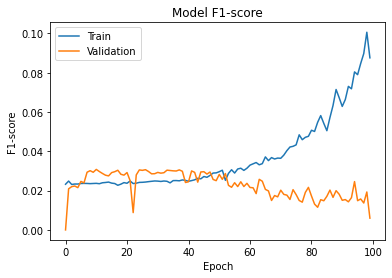

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

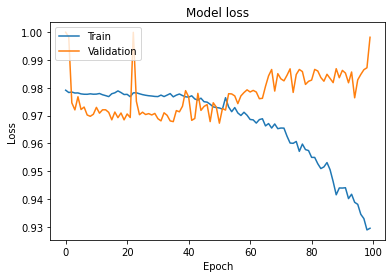

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Testing

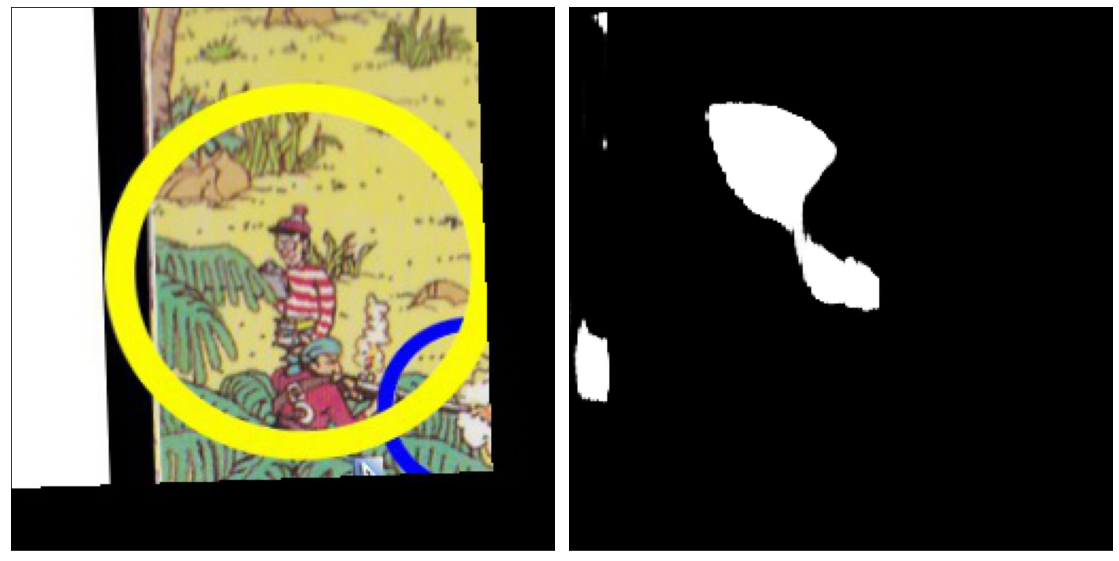

In [15]:
#model = unet_v1(loss=losses[LOSS_FUNCTION],
#                metrics=[f1_score],
#                input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
model = unet_v2(loss=losses[LOSS_FUNCTION],
                metrics=[f1_score],
                input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
model.load_weights('models/unet_v2.f1lo-b14-e100.100.hdf5')

img = load_img('data/aug/train/2_image.jpg',
               target_size=(IMG_HEIGHT, IMG_WIDTH))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

result = model.predict(x)[0]

f, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].imshow(img)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
mask = result[:, :, 0] * 255.0
#mask[mask > 0.5] = 255
#mask[mask <= 0.5] = 0
axes[1].imshow(mask, cmap='gray', vmin=0, vmax=255)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)